In [1]:
import sys # for gioia to load aiohttp
sys.path.append('/Users/maggiori/anaconda/envs/py35/lib/python3.5/site-packages')

In [2]:
# to import modules locally even if the package hasn't been installed
# http://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import os, sys, inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

In [3]:
import time
import signal
import subprocess
import numpy as np
from scipy.stats import norm
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook')

In [4]:
from timeseries import *

Generating LALR tables


# Stock Market Similarity Searches: Daily Returns

We have provided a year of daily returns for 379 S&P 500 stocks. We have explicitly excluded stocks with incomplete or missing data. We have pre-loaded 350 stocks in the database, and have excluded 29 stocks for later use in similarity searches.

Data source: <a href='www.stockwiz.com'>www.stockwiz.com</a>

In [5]:
# load data
with open('data/returns_include.json') as f:    
    stock_data_include = json.load(f)
with open('data/returns_exclude.json') as f:    
    stock_data_exclude = json.load(f)

# keep track of which stocks are included/excluded from the database
stocks_include = list(stock_data_include.keys())
stocks_exclude = list(stock_data_exclude.keys())
    
# check the number of market days in the year
num_days = len(stock_data_include[stocks_include[0]])
num_days

244

### Database Initialization

Let's start by initializing all the database components.

In [6]:
# 1. load the database server

# when running from the terminal
# python go_server_persistent.py --ts_length 244 --db_name 'stock_prices'

# here we load the server as a subprocess for demonstration purposes
server = subprocess.Popen(['python', '../go_server_persistent.py',
                           '--ts_length', str(num_days), '--data_dir', '../db_files', '--db_name', 'stock_returns'])
time.sleep(5)  # make sure it loads completely

# 2. load the database webserver

# when running from the terminal
# python go_webserver.py

# here we load the server as a subprocess for demonstration purposes
webserver = subprocess.Popen(['python', '../go_webserver.py'])
time.sleep(5)  # make sure it loads completely

# 3. import the web interface and initialize it

from webserver import *
web_interface = WebInterface()

### Stock Data Initialization

The database is now up and running. We have pre-loaded the data for you, but you can always unquote the code below to re-load the data if you accidentally delete it.

In [7]:
# # insert into database
# for stock in stocks_include:
#     web_interface.insert_ts(pk=stock, ts=TimeSeries(range(num_days), stock_data_include[stock]))

Let's look at the first 10 stocks, to check that the data has been loaded correctly.

In [8]:
# let's look at the first 10 stocks
web_interface.select(fields=None, additional={'sort_by': '+pk', 'limit': 10})

OrderedDict([('A', OrderedDict()),
             ('AA', OrderedDict()),
             ('ABC', OrderedDict()),
             ('ABT', OrderedDict()),
             ('ADI', OrderedDict()),
             ('ADM', OrderedDict()),
             ('AEE', OrderedDict()),
             ('AEP', OrderedDict()),
             ('AES', OrderedDict()),
             ('AET', OrderedDict())])

Let's check how many stocks are currently in the database (should be 350).

In [9]:
len(web_interface.select())

350

### Vantage Point Search

We need to initialize vantage points in order to carry out a vantage point search. Again, this has already been done for you, but you can re-create the results by running the following code.

In [10]:
# # randomly pick vantage points
# # note: this can be time-intensive for a large number of vantage points
# num_vps = 10
# random_vps = np.random.choice(len(stocks_include), size=num_vps, replace=False)
# vpkeys = [stocks_include[s] for s in random_vps]

# # mark in database
# for vp in vpkeys:
#     web_interface.insert_vp(vp)

Let's pick one of our excluded stocks and carry out a vantage point similarity search.

Stock: MDP
Most similar stock: LUK


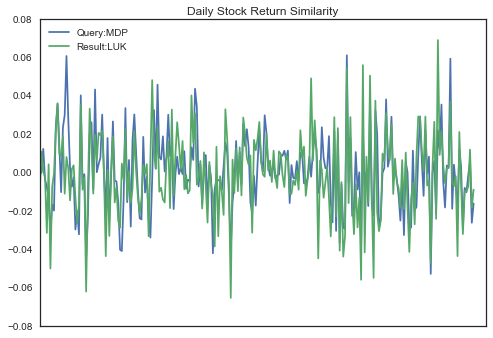

In [11]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the vantage point similarity search
result = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]), 1)
print('Most similar stock:', list(result)[0])

# visualize similarity
plt.plot(stock_data_exclude[stock], label='Query:' + stock)
plt.plot(stock_data_include[list(result)[0]], label='Result:' + list(result)[0])
plt.xticks([])
plt.legend(loc='best')
plt.title('Daily Stock Return Similarity')
plt.show()

### iSAX Tree Search

Let's pick another one of our excluded stocks and carry out an iSAX tree similarity search. Note that this is an approximate search technique, so it will not always be able to find a similar stock.

Stock: RF
Most similar stock: FO


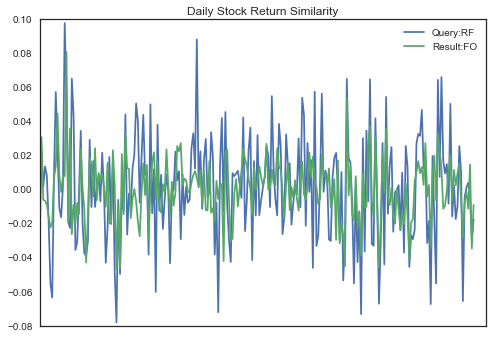

In [12]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the isax tree similarity search
result = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]))

# could not find a match
if result == 'ERROR: NO_MATCH':
    print('Could not find a similar stock.')

# found a match
else:
    print('Most similar stock:', list(result)[0])
    
    # visualize similarity
    plt.plot(stock_data_exclude[stock], label='Query:' + stock)
    plt.plot(stock_data_include[list(result)[0]], label='Result:' + list(result)[0])
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Daily Stock Return Similarity')
    plt.show()

### Comparing Similarity Searches

Now, let's pick one more random stock, carry out both types of similarity searches, and compare the results.

Stock: UTX
VP search result: HON
iSAX search result: WMT


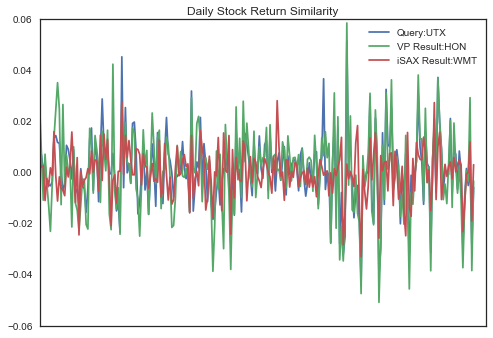

In [13]:
# pick the stock
stock = np.random.choice(stocks_exclude)
print('Stock:', stock)

# run the vantage point similarity search
result_vp = web_interface.vp_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]), 1)
print('VP search result:', list(result_vp)[0])

# run the isax similarity search
result_isax = web_interface.isax_similarity_search(TimeSeries(range(num_days), stock_data_exclude[stock]))

# could not find an isax match
if result_isax == 'ERROR: NO_MATCH':
    print('iSAX search result: Could not find a similar stock.')

# found a match
else:
    print('iSAX search result:', list(result_isax)[0])
    
    # visualize similarity
    plt.plot(stock_data_exclude[stock], label='Query:' + stock)
    plt.plot(stock_data_include[list(result_vp)[0]], label='VP Result:' + list(result_vp)[0])
    plt.plot(stock_data_include[list(result_isax)[0]], label='iSAX Result:' + list(result_isax)[0])
    plt.xticks([])
    plt.legend(loc='best')
    plt.title('Daily Stock Return Similarity')
    plt.show()

### iSAX Tree Representation

Finally, let's visualize the iSAX tree. The clusters represent groups of "similar" stocks.

In [14]:
print(web_interface.isax_tree())

root
--->['01', '10', '01', '10']: 0 []
------>['011', '100', '011', '100']: 0 []
--------->['0111', '1000', '0111', '1000']: 0 []
------------>['01111', '10000', '01111', '10000']: 0 []
--------------->['011110', '100001', '011111', '100000']: 1 ['LH']
--------------->['011111', '100000', '011111', '100000']: 3 ['CSX', 'GR', 'OMC']
--------------->['011110', '100000', '011111', '100000']: 1 ['NSC']
--------------->['011110', '100000', '011111', '100001']: 2 ['HON', 'PBI']
--------------->['011111', '100000', '011110', '100000']: 1 ['TIE']
------------>['01110', '10001', '01110', '10001']: 2 ['HOG', 'MCK']
------------>['01110', '10000', '01111', '10000']: 2 ['NKE', 'RL']
------------>['01111', '10000', '01111', '10001']: 3 ['JCP', 'LMT', 'MAS']
------------>['01111', '10000', '01110', '10000']: 1 ['PFG']
------------>['01110', '10000', '01111', '10001']: 4 ['ICE', 'K', 'PXD', 'WAT']
------------>['01110', '10001', '01111', '10000']: 1 ['ITW']
------------>['01111', '10001', '01110', '

### Termination

Always remember to terminate any outstanding processes!

In [15]:
# terminate processes before exiting
os.kill(server.pid, signal.SIGINT)
time.sleep(5)  # give it time to terminate
web_interface = None
webserver.terminate()